In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [49]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled by the convolutional blocks.
# We will be using two convolution blocks and each block will have a pooling layer
# which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

In [50]:
# # Path to the data directory
# data_dir = Path("./samples/")

# dir_img = sorted(list(map(str, list(data_dir.glob("*.jpg")))))[:20000] 
# LABELS = [img.split(os.path.sep)[-1]. 
#             split(".jpg")[0] for img in dir_img] 
# CHARS = set(char for label in LABELS for char in label) 

# print("Number of dir_img found: ", len(dir_img)) 
# print("Number of img_labels found: ", len(LABELS)) 
# print("Number of unique char_img: ", len(CHARS)) 
# print("Characters present: ", CHARS) 

In [51]:
# Path to the data directory
data_dir = Path("./samples/")

dir_img = sorted(list(map(str, list(data_dir.glob("*.png")))))
LABELS = [img.split(os.path.sep)[-1]. 
            split(".png")[0] for img in dir_img] 
CHARS = set(char for label in LABELS for char in label) 

print("Number of dir_img found: ", len(dir_img)) 
print("Number of img_labels found: ", len(LABELS)) 
print("Number of unique char_img: ", len(CHARS)) 
print("Characters present: ", CHARS) 

Number of dir_img found:  1040
Number of img_labels found:  1040
Number of unique char_img:  19
Characters present:  {'y', 'n', '7', 'd', '3', 'b', 'x', 'w', 'p', '6', 'm', '8', 'g', '5', '4', '2', 'f', 'e', 'c'}


In [52]:
# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in LABELS])
max_length

5

In [53]:
# Char to integers 
char_to_num = layers.StringLookup( 
    vocabulary=list(CHARS), mask_token=None
) 

# Integers to original chaecters 
num_to_char = layers.StringLookup( 
    vocabulary=char_to_num.get_vocabulary(), 
    mask_token=None, invert=True
) 

def encode_sample(img_path, label): 
    # Read the image 
    img = tf.io.read_file(img_path) 
    # Converting the image to grayscale 
    img = tf.io.decode_png(img, channels=1) 
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # Resizing to the desired size 
    img = tf.image.resize(img, [img_height, img_width]) 
    # Transposing the image 
    img = tf.transpose(img, perm=[1, 0, 2]) 
    # Mapping image label to numbers 
    label = char_to_num(tf.strings.unicode_split(label, 
                                                input_encoding="UTF-8")) 

    return {"image": img, "label": label} 

In [54]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred, num_to_char, max_length):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def data_split(dir_img, img_labels, 
            train_size=0.9, shuffle=True): 
    # Get the total size of the dataset 
    size = len(dir_img) 
    # Create an indices array and shuffle it if required 
    indices = np.arange(size) 
    if shuffle: 
        np.random.shuffle(indices) 
    # Calculate the size of training samples 
    train_samples = int(size * train_size) 
    # Split data into training and validation sets 
    x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]] 
    x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]] 
    return x_train, x_valid, y_train, y_valid 


In [55]:
# Split data into training and validation sets 
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), 
                                np.array(LABELS)) 

print(f"X_Train shape: {x_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {y_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (936,)
y_Train shape: (936,)
X_valid shape: (104,)
y_valid shape: (104,)


In [56]:
# Creating training dataset 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_dataset = ( 
	train_dataset.map( 
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE 
	) 
	.batch(batch_size) 
	.prefetch(buffer_size=tf.data.AUTOTUNE) 
) 


# Creating validation dataset 
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) 
validation_dataset = ( 
	validation_dataset.map( 
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE 
	) 
	.batch(batch_size) 
	.prefetch(buffer_size=tf.data.AUTOTUNE) 
)


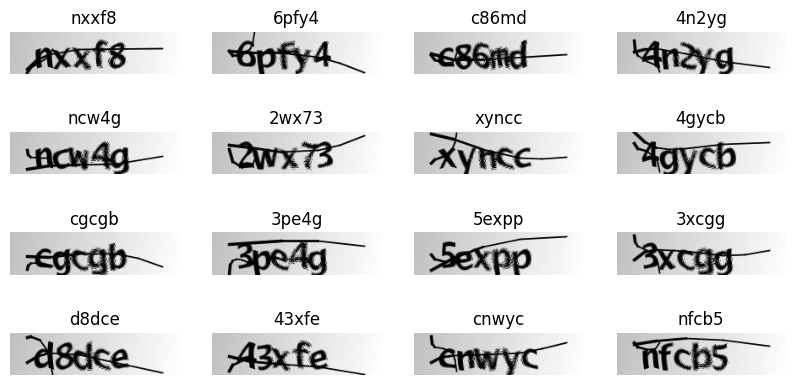

In [57]:
# Visualizing some training data 
_, ax = plt.subplots(4, 4, figsize=(10, 5)) 
for batch in train_dataset.take(1): 
	dir_img = batch["image"] 
	LABELS = batch["label"] 
	for i in range(16): 
		img = (dir_img[i] * 255).numpy().astype("uint8") 
		label = tf.strings.reduce_join(num_to_char( 
			LABELS[i])).numpy().decode("utf-8") 
		ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray") 
		ax[i // 4, i % 4].set_title(label) 
		ax[i // 4, i % 4].axis("off") 
plt.show() 

In [58]:
# CTC loss calculation 
@tf.keras.utils.register_keras_serializable()
class LayerCTC(layers.Layer): 
	def __init__(self, name=None, **kwargs): 
		super().__init__(name=name) 
		self.loss_fn = keras.backend.ctc_batch_cost 

	def call(self, y_true, y_pred): 
		# Compute the training-time loss value 
		batch_len = tf.cast(tf.shape(y_true)[0], 
							dtype="int64") 
		input_length = tf.cast(tf.shape(y_pred)[1], 
							dtype="int64") 
		label_length = tf.cast(tf.shape(y_true)[1], 
							dtype="int64") 

		input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") 
		label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64") 

		loss = self.loss_fn(y_true, y_pred, 
							input_length, label_length) 
		self.add_loss(loss) 

		# Return Computed predictions 
		return y_pred 

def get_model(): 
	# Define the inputs to the model 
	input_img = layers.Input( 
		shape=(img_width, img_height, 1), 
		name="image", dtype="float32"
	) 
	img_labels = layers.Input(name="label", 
							shape=(None,), 
							dtype="float32") 

	# First convolutional block 
	x = layers.Conv2D( 
		32, 
		(3, 3), 
		activation="relu", 
		kernel_initializer="he_normal", 
		padding="same", 
		name="Conv1", 
	)(input_img) 
	x = layers.MaxPooling2D((2, 2), name="pool1")(x) 

	# Second convolutional block 
	x = layers.Conv2D( 
		64, 
		(3, 3), 
		activation="relu", 
		kernel_initializer="he_normal", 
		padding="same", 
		name="Conv2", 
	)(x) 
	x = layers.MaxPooling2D((2, 2), name="pool2")(x) 

	# Reshaping the output before passing to RNN 
	new_shape = ((img_width // 4), (img_height // 4) * 64) 
	x = layers.Reshape(target_shape=new_shape, name="reshape")(x) 
	x = layers.Dense(64, activation="relu", name="dense1")(x) 
	x = layers.Dropout(0.2)(x) 

	# RNNs 
	x = layers.Bidirectional(layers.LSTM( 
		128, return_sequences=True, dropout=0.25))(x) 
	x = layers.Bidirectional(layers.LSTM( 
		64, return_sequences=True, dropout=0.25))(x) 

	# Output layer 
	x = layers.Dense( 
		len(char_to_num.get_vocabulary()) + 1, 
		activation="softmax", name="dense2"
	)(x) 

	# Calculate CTC loss at each step 
	output = LayerCTC(name="ctc_loss")(img_labels, x) 

	# Defining the model 
	model = keras.models.Model( 
		inputs=[input_img, img_labels], 
		outputs=output, 
		name="ocr_model_v1"
	) 
	opt = keras.optimizers.Adam() 

	# Compile the model 
	model.compile(optimizer=opt) 

	return model 


In [59]:
model = get_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [ ]:
epochs = 100
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

In [ ]:
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)

prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

1/1 [==============================] - 2s 2s/step


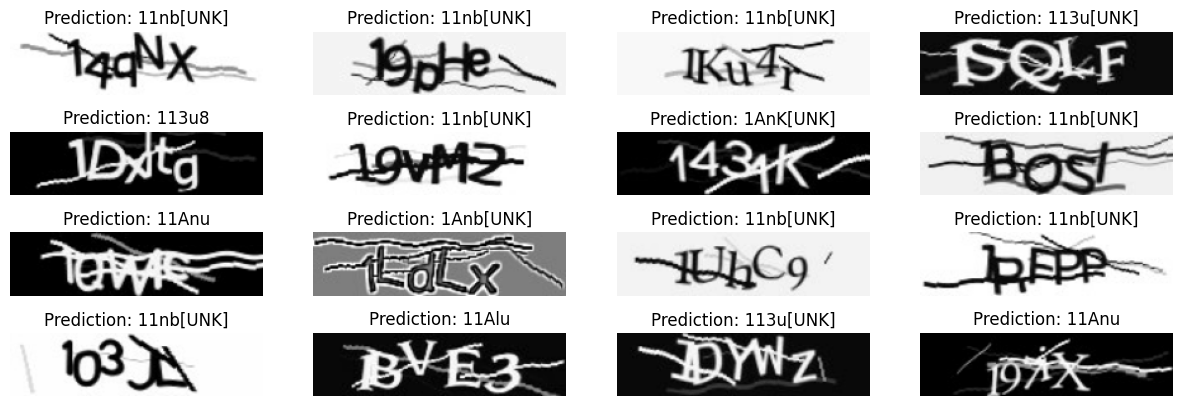

In [ ]:
# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, num_to_char, max_length)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")        
plt.show()

In [ ]:
# Lista para armazenar as previsões decodificadas
predicted_texts = []

# Lista para armazenar os rótulos verdadeiros
true_texts = []

# Iterar sobre os dados de validação e fazer previsões
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    # Fazer previsões
    preds = prediction_model.predict(batch_images)
    
    # Decodificar as previsões
    pred_texts = decode_batch_predictions(preds, num_to_char, max_length)
    
    # Decodificar os rótulos verdadeiros
    for label in batch_labels:
        true_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        true_texts.append(true_text)
    
    # Adicionar previsões decodificadas à lista
    predicted_texts.extend(pred_texts)

# Calcular a precisão
correct_predictions = sum(1 for true, pred in zip(true_texts, predicted_texts) if true == pred)
total_samples = len(true_texts)
accuracy = correct_predictions / total_samples

print("Accuracy:", accuracy)


1/1 [==============================] - 0s 35ms/step
Accuracy: 0.0


In [ ]:
test_loss = model.evaluate(validation_dataset)
test_loss

7/7 [==============================] - 0s 27ms/step - loss: 0.1160


0.11599374562501907

In [ ]:

def predict_from_image_path(model, img_path, num_to_char, max_length, img_height=50, img_width=200):
    # Carregar a imagem do caminho fornecido
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)  # Adicionando dimensão de lote
    
    # Fazer previsão
    pred = model.predict(img)
    print(type(pred))
    
    # Decodificar a previsão
    pred_text = decode_batch_predictions(pred, num_to_char, max_length)[0]
    
    return pred_text


In [ ]:
img_path = r"samples\3eny7.png"
prediction = predict_from_image_path(prediction_model, img_path, num_to_char, max_length)
print("Prediction:", prediction)

1/1 [==============================] - 0s 36ms/step
Prediction: 3eny7


In [ ]:
def save_model(model, char_to_num, num_to_char, LABELS, filename):
    # Salvar o modelo
    char_to_num_dict = char_to_num.get_vocabulary()
    num_to_char_dict = num_to_char.get_vocabulary()


    data = {
        'model': model,
        'labels': LABELS,
        'char_to_num': char_to_num_dict,
        'num_to_char': num_to_char_dict
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
# Salvar o modelo e os mapeamentos
save_model(prediction_model, char_to_num, num_to_char, LABELS, 'model1.pkl')


In [ ]:
def load_model(filename):
    # Carregar o mapeamento char_to_num do arquivo pickle
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        
    char_to_num = layers.StringLookup( 
        vocabulary=list(data['char_to_num']), mask_token=None
    ) 

    num_to_char = layers.StringLookup( 
        vocabulary=list(data['num_to_char']), 
        mask_token=None, invert=True
    ) 
    
    data['num_to_char'] = num_to_char
    data['char_to_num'] = char_to_num
    
    return data 

In [ ]:
data = load_model('model1.pkl')

In [ ]:
img_path = r"samples\2gyb6.png"
prediction = predict_from_image_path(data['model'], img_path, data['num_to_char'], max([len(label) for label in data['labels']]))
print("Prediction:", prediction)

1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
Prediction: 2gyb6


In [ ]:
type(num_to_char)

keras.src.layers.preprocessing.string_lookup.StringLookup